In [ ]:
import torch
import matplotlib.pyplot as plt

# Aprendizaje

> Autor: Jorge García González (Universidad de Málaga)

> Última Actualización: 15/09/2025

> Asignatura: Programación para la Inteligencia Artificial

¿Qué entendemos por *aprender* en el contexto de las Redes Neuronales Artificiales? Ajustar los parámetros de un modelo.

Antes de empezar con las redes, vamos a observar el fenómeno del ajuste de parámetros en un modelo mucho más sencillo. Vamos a hacer un modelo que ajuste una recta a partir de unos datos.

Recordemos que la ecuación de una recta en 2 dimensiones es y=m*x+b. Por tanto una recta solo tiene dos parámetros que ajustar, la m (inclinación) y la b (valor donde se corta el eje y).

Lo primero que necesitamos es una función que, dados los parámetros de una recta, nos devuelva un conjunto de puntos que formen parte de esa recta. Para hacerlo un poquito más realista vamos a añadirle ruido gaussiano a esos datos. Así los puntos no encajarán perfectamente en la recta, pero deberían estar cerca.

Los datos en problemas reales rara vez son perfectos y nuestros modelos son solo aproximaciones.

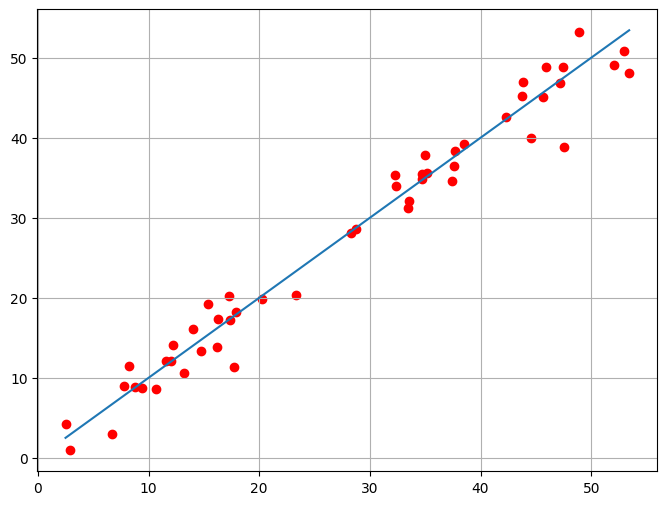

In [3]:
def get_data_from_a_line(m, b, n, sigma=2, range=50):
  """
  Función que devuelve datos a partir de una recta. Recordemos que la ecuación de la recta está definida por y=mx+b.
  Args:
    m: inclinación de la recta.
    b: ordenada en el origen de la recta.
    n: número de datos que queremos obtener.
    sigma: desviación típica para el ruido que añadiremos a los datos (2 por defecto).
    range: extremo del rango [0,rango] en el eje x en el que queremos situar los datos (50 por defecto).
  """
  x = range*torch.rand(n)                                               # Generamos los datos en el eje x.
  y = m*x+b                                                             # Obtemeos la posición correspondiente en el eje y.
  noise_x = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y)) # Generamos un vector de ruido gaussiano para el eje x.
  noise_y = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y)) # Generamos un vector de ruido gaussiano para el eje y.
  x_with_noise = x + noise_x
  y_with_noise = y + noise_y

  data = torch.cat((x_with_noise[:,None], y_with_noise[:,None]), dim=1)
  return data

def plot_line_with_data(m,b,data):
  """
  Procedimiento para dibujar una recta y un conjunto de puntos.
  Args:
    m: inclinación de la recta.
    b: ordenada en el origen.
    data: tensor de puntos con tamaño Nx2.
  """

  x = data[:,0]
  y = data[:,1]
  plt.figure(figsize=(8,6))
  plt.scatter(x, y, marker='o', c='r')
  plt.plot([x.min(),x.max()], [m*x.min()+b,m*x.max()+b])
  plt.grid(True)
  plt.show()

data = get_data_from_a_line(1,0,50)
plot_line_with_data(1,0,data)


Una vez podemos generar un conjunto de datos "del que aprender", vamos a crear nuestro modelo de recta. Este modelo se trata solo de aplicar la ecuación de la recta a unas entradas dados unos parámetros de la misma. Nótese que si podemos asumir que nuestro modelo a aprender tiene esta estructura es porque nosotros (diseñadores del sistema) *sabemos* que es una recta. Este modelo será incapaz de aprender de manera precisa datos que no provengan de una recta. Es un modelo muy limitado, pero que se ajusta a nuestras necesidades actuales.

In [4]:
def line_model(m, b, inputs):
  """
  Functión para modelar una recta.
  Args:
    m: inclinación de la recta.
    b: ordenada en el origen de la recta.
    inputs: vector con los valores de entrada para ser calculados por el modelo.
  """
  return m*inputs+b

Tenemos datos y un modelo que ajustar. ¿Ahora qué? ¿Cómo lo ajustamos?

Por simplificar, vamos a a suponer que el valor de b (la ordenada en el origen) es siempre cero, así que solo tendríamos que ajustar la inclinación de una recta que pase por el (0,0) a unos datos obtenidos. No sabemos qué recta originaron los datos (bueno, sí que lo sabemos, pero vamos a fingir que no), así que nuestra estrategia va a ser ir probando y ver si la recta que vamos obteniendo se ajusta mejor o peor.

Para saber si se ajusta mejor o peor tenemos que poder cuantificar el *error* que cometemos en cada una de nuestras pruebas. Para eso vamos a definir un par de funciones de error (también llamadas funciones de pérdida o funciones de coste) muy habituales: el error absoluto y el error cuadrático.

In [5]:
def AE_loss(y_pred, y_true):
  return torch.abs(y_pred - y_true)

def SE_loss(y_pred, y_true):
  return (y_pred-y_true)**2

Puede ser llamativo el nombre que hemos decidido darle a los argumentos de estas funciones. y_pred hace referencia a la predicción que hace el modelo, mientras que y_true hace referencia a un valor que tomamos como verdadero. Estas funciones tienen este aspecto:

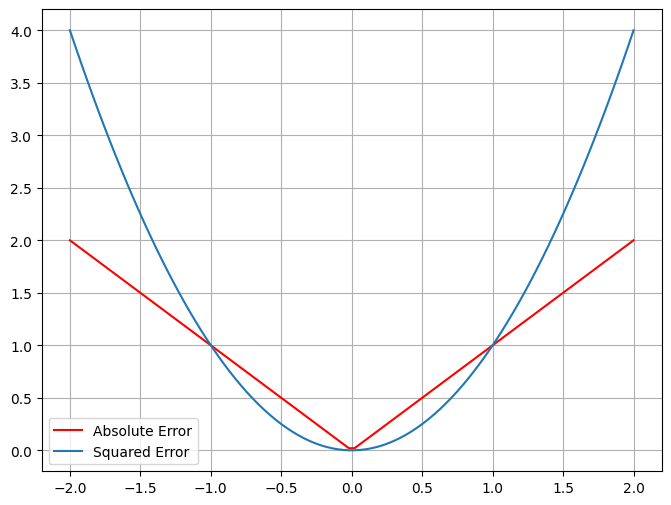

In [6]:
x = torch.linspace(-2,2,100)
ae = torch.abs(x)
se = x**2
plt.figure(figsize=(8,6))
plt.plot(x, ae, label="Absolute Error", c="r")
plt.plot(x, se, label="Squared Error")
plt.legend()
plt.grid(True)
plt.show()

Aunque su comportamiento general es parecido, hay algunas diferencias interesantes. La más obvia es que en valores de x ∈ (-1,1), el error cuadrático es menor que el error absoluto. Para el resto de los valores es igual (para {-1,1}) o mayor, y de hecho crece más rápido que el error absoluto. Comparemoslas en dos puntos distintos. Para x=0.5, el error absoluto señalará que hay un error de 0.5, mientras que el error cuadrático indicará que el error es de 0.25. Para x=2, el error absoluto indicará un error de 2, mientras que el error cuadrático indicará un error de 4. para x=3, el error absoluto indicará 3, el cuadrático indicará 9. ¡Es importante tener en cuenta el rango de valores en el que nos vamos a mover!

Hay una diferencia relevante más: el error cuadrático es derivable en todos los puntos, mientras que el error absoluto no es derivable en el 0. Por ahora no vamos a prestarle atención a eso, pero en el futuro volveremos a ese detalle.

Ahora que tenemos un par de maneras de cuantificar el *error* de nuestro problema. Vamos a ver cómo van encajando las piezas.

Si seguimos nuestra estrategia de *prueba y error*, lo que haríamos es tomar un punto cualquiera (xₙ,yₙ) de los datos de los que queremos aprender y lo vamos a *fijar*. Nuestros datos nos dicen que para x=xₙ, el modelo tendría que tener yₙ como resultado si estuviera bien ajustado. Ajustar el modelo en este caso, como hemos mencionado antes, consiste en ajustar el parámetro m (porque por simplificar el ejemplo asumimos b=0). Así que nuestras funciones de error lo que van a medir es la diferencia entre el resultado que consideramos cierto (yₙ) y el resultado que obtenemos (xₙ*m+b).

Vamos a ver qué aspecto tiene esa función de error según cómo modificamos m para un punto elegido arbitrariamente.

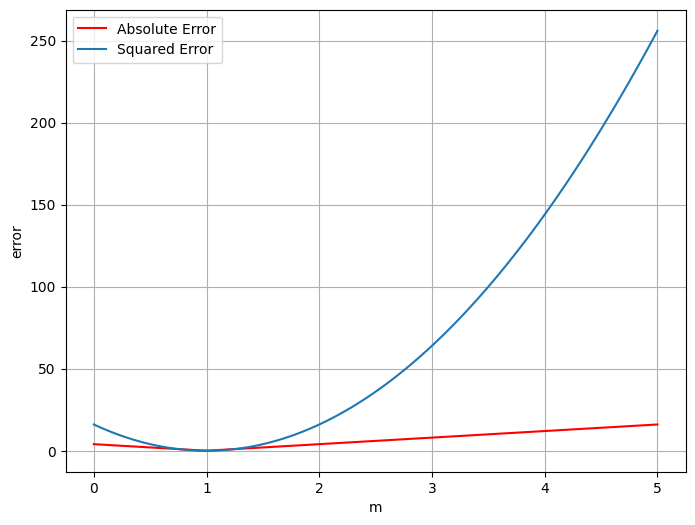

In [7]:
x_true, y_true = (4,4)
ae_list = []
se_list = []
b=0

m= torch.linspace(0,5,100)
y_pred = line_model(m,b,x_true)
ae_error = AE_loss(y_pred, y_true)
se_error = SE_loss(y_pred, y_true)

plt.figure(figsize=(8,6))
plt.plot(m, ae_error, label="Absolute Error", c="r")
plt.plot(m, se_error, label="Squared Error")
plt.legend()
plt.grid(True)
plt.xlabel("m")
plt.ylabel("error")
plt.show()

Como era de esperar, alterar la inclinación de nuestro modelo de recta tiene como consecuencia un cambio en el error. Podemos ver que el error se minimiza en m=1. Esto tiene sentido, ya que el punto (4,4) forma parte de la recta y=x. Si no hubieramos asumido b=0, habría infinitas soluciones que minimizan un punto dado.

Con puntos que pertenezcan a rectas distintas obtendríamos curvas distintas.

Ahora que hemos visto cómo encaja la función de error con el modelo y los datos, vamos a intentar definir un algoritmo de optimización iterativo. Una opción sería probar valores aleatorios para m y cada vez que encontremos uno que tenga un error más bajo, actualizar m. Es una opción totalmente aleatoria que para un caso sencillo como este podría parecer una opción aceptable, pero vamos a ir un paso más allá. Vamos a aprovechar la función de error para saber en qué dirección actualizar m.

Dado un punto (xₙ,yₙ) de los datos de entrenamiento y un valor del parámetro m=mₛ, vamos a estudiar qué ocurre si incrementamos o disminuimos ligeramente el parámetro m. Para eso vamos a definir un valor Δ y vamos a estudiar qué recta se ajusta mejor al punto dado, la recta con parámetro m=mₛ+Δ o la recta con parámetro m=mₛ-Δ.

La diferencia entre uno y otro la vamos a llamar ratio de cambio del error y vamos a actualizar el parámetro m con ese por un ratio de aprendizaje.

Usaremos el error absoluto para evitar retios de cambio del error muy grandes.

--------- step 0
m actual: 0.8
Dato escogido aleatoriamente (x_true,y_true): (tensor(30.6232), tensor(14.4707))
Valor de y predicho: 24.498546600341797
Valor de y predicho 'bajando la m': 21.436227798461914, error: 6.965547561645508
Valor de y predicho 'aumentando la m': 27.560863494873047, error: 13.09018325805664
Ratio de cambio en la pérdida de m: -30.623178482055664, multiplicado por el ratio de aprendizaje: -0.03062318079173565
--------- step 1
m actual: 0.769376814365387
Dato escogido aleatoriamente (x_true,y_true): (tensor(43.0127), tensor(20.6768))
Valor de y predicho: 33.09295654296875
Valor de y predicho 'bajando la m': 28.79168701171875, error: 8.114866256713867
Valor de y predicho 'aumentando la m': 37.39422607421875, error: 16.717405319213867
Ratio de cambio en la pérdida de m: -43.0126953125, multiplicado por el ratio de aprendizaje: -0.043012697249650955
--------- step 2
m actual: 0.7263641357421875
Dato escogido aleatoriamente (x_true,y_true): (tensor(39.1849), tensor(1

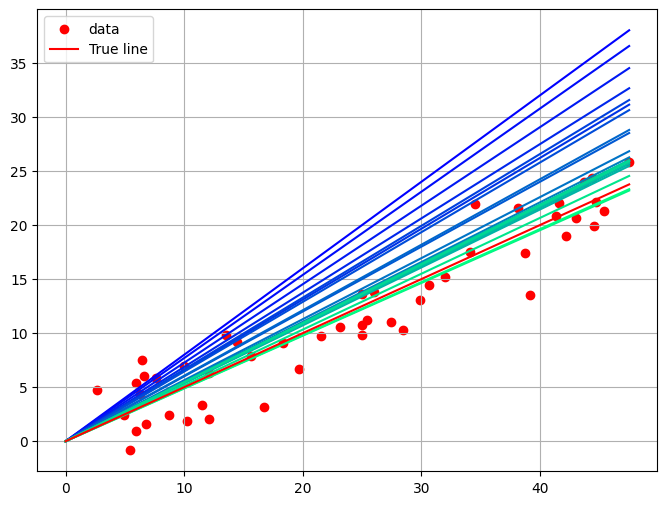

In [8]:
learning_rate = 1e-3
delta = 0.1
steps = 20
loss_fn = AE_loss

true_m, true_b = [0.5,0]
data = get_data_from_a_line(true_m, true_b, 50)
m = 0.8                                         # Inicializamos la m a 0.8 con propósitos meramente didácticos. Debería ser aleatorio.
b = 0
line_evolution = [m]

for step in range(steps):
  random_index_to_select_data = torch.randint(low=0, high=data.size()[0], size=(1,))[0]
  random_point_from_data = data[random_index_to_select_data]
  x_true = random_point_from_data[0]
  y_true = random_point_from_data[1]

  loss_rate_of_change_m = (loss_fn(line_model(m-delta,b,x_true), y_true) - loss_fn(line_model(m+delta,b,x_true), y_true)) / (2*delta)
  print(f"--------- step {step}")
  print(f"m actual: {m}")
  print(f"Dato escogido aleatoriamente (x_true,y_true): {x_true,y_true}")
  print(f"Valor de y predicho: {line_model(m,b,x_true)}")
  print(f"Valor de y predicho 'bajando la m': {line_model(m-delta,b,x_true)}, error: {loss_fn(line_model(m-delta,b,x_true), y_true)}")
  print(f"Valor de y predicho 'aumentando la m': {line_model(m+delta,b,x_true)}, error: {loss_fn(line_model(m+delta,b,x_true), y_true)}")
  print(f"Ratio de cambio en la pérdida de m: {loss_rate_of_change_m}, multiplicado por el ratio de aprendizaje: {learning_rate*loss_rate_of_change_m}")
  m = m + learning_rate*loss_rate_of_change_m
  line_evolution.append(m)

print(line_evolution)
plt.figure(figsize=(8,6))
colors = plt.cm.winter(torch.linspace(0,1,steps+1))
for index, m in enumerate(line_evolution):
  plt.plot([0,data.max()], [0,m*data.max()], c=colors[index])
plt.scatter(data[:,0], data[:,1], marker='o', c='r', label="data")
plt.plot([0,data.max()], [0,true_m*data.max()], c='r', label="True line")
plt.legend()
plt.grid(True)
plt.show()



En la gráfica podemos ver cómo la evolución de la recta (las azules son los primeros pasos y las verdes los últimos) se acerca a la recta que usamos para generar los datos (rojo). Si analizamos la evolución numérica podemos ver que es algo irregular. A veces los ratios de cambio están en el orden de varias decenas y otras veces están en el orden de las décimas. A veces son positivos y otras veces negativos. Esto puede ocurrir, aunque es indeseable que un entrenamiento sea tan *inestable*. En este caso uno de los principales sospechosos de que ocurra es que los datos tienen ruido. Muy pocos de los datos que tenemos se ajustan bien a la recta con la que fueron generados. Como cogemos un dato de referencia cada vez, este dato puede quedar más o menos lejos de la recta que representa nuestro modelo en cada paso. ¡Puede incluso hacer que nuestro modelo se ajuste en la dirección equivocada!

Por suerte, eso tiene fácil solución. No cojamos un único dato. Vamos a usarlos todos en cada paso de entrenamiento. Para eso primero hay que hacerle unos pequeños ajustes a nuestras funciones de error.

In [9]:
def MAE_loss(y_pred, y_true):
  """
  Función para calcular la media del error absoluto.
  """
  absolute_error = torch.abs(y_pred-y_true)
  return absolute_error.mean()

def MSE_loss(y_pred, y_true):
  """
  Función para calcular la media del error cuadrático.
  """
  squared_error = (y_pred-y_true)**2
  return squared_error.mean()

Una vez nuestras funciones de error obtienen valores medios, podemos ajustar el proceso de entrenamiento del modelo para que trabaje con todos los datos siempre.

--------- step 0
m actual: 0.8
Valor medio de y: 12.053668975830078
Valor medio de y predicho: 19.94540786743164
Valor medio de y predicho 'bajando la m': 17.452232360839844, error: 5.587164402008057
Valor medio de y predicho 'aumentando la m': 22.438583374023438, error: 10.409149169921875
Ratio de cambio en la pérdida de m: -24.10992431640625, multiplicado por el ratio de aprendizaje: -0.02410992607474327
--------- step 1
m actual: 0.7758901119232178
Valor medio de y: 12.053668975830078
Valor medio de y predicho: 19.34430503845215
Valor medio de y predicho 'bajando la m': 16.85112953186035, error: 5.039474964141846
Valor medio de y predicho 'aumentando la m': 21.837482452392578, error: 9.827775001525879
Ratio de cambio en la pérdida de m: -23.941499710083008, multiplicado por el ratio de aprendizaje: -0.02394150011241436
--------- step 2
m actual: 0.7519485950469971
Valor medio de y: 12.053668975830078
Valor medio de y predicho: 18.747400283813477
Valor medio de y predicho 'bajando la

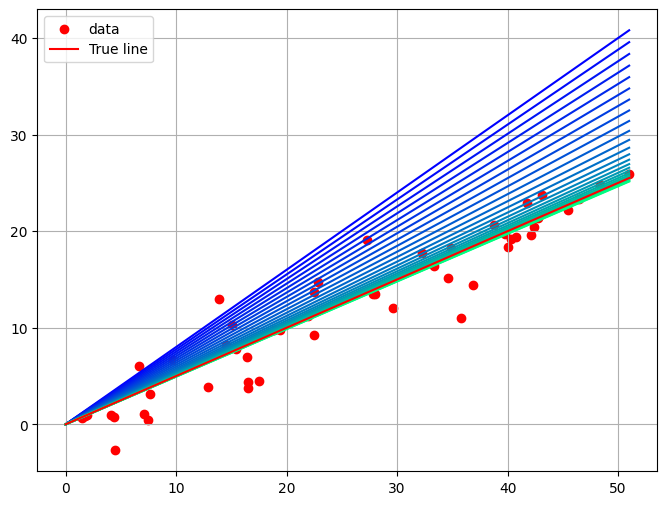

In [18]:
learning_rate = 1e-3
delta = 0.1
steps = 25
loss_fn = MAE_loss

true_m, true_b = [0.5,0]
data = get_data_from_a_line(true_m, true_b, 50)
m = 0.8                                         # Inicializamos la m a 0.8 con propósitos meramente didácticos.
b = 0
line_evolution = [m]

for step in range(steps):
  x_true = data[:,0]
  y_true = data[:,1]

  loss_rate_of_change_m = (loss_fn(line_model(m-delta,b,x_true), y_true) - loss_fn(line_model(m+delta,b,x_true), y_true)) / (2*delta)
  print(f"--------- step {step}")
  print(f"m actual: {m}")
  print(f"Valor medio de y: {y_true.mean()}")
  print(f"Valor medio de y predicho: {line_model(m,b,x_true).mean()}")
  print(f"Valor medio de y predicho 'bajando la m': {line_model(m-delta,b,x_true).mean()}, error: {loss_fn(line_model(m-delta,b,x_true), y_true)}")
  print(f"Valor medio de y predicho 'aumentando la m': {line_model(m+delta,b,x_true).mean()}, error: {loss_fn(line_model(m+delta,b,x_true), y_true)}")
  print(f"Ratio de cambio en la pérdida de m: {loss_rate_of_change_m}, multiplicado por el ratio de aprendizaje: {learning_rate*loss_rate_of_change_m}")
  m = m + learning_rate*loss_rate_of_change_m
  line_evolution.append(m)

plt.figure(figsize=(8,6))
colors = plt.cm.winter(torch.linspace(0,1,steps+1))
for index, m in enumerate(line_evolution):
  plt.plot([0,data.max()], [0,m*data.max()], c=colors[index])
plt.scatter(data[:,0], data[:,1], marker='o', c='r', label="data")
plt.plot([0,data.max()], [0,true_m*data.max()], c='r', label="True line")
plt.legend()
plt.grid(True)
plt.show()

¡Lo que cambia una media! Ahora el ajuste es numéricamente estable, el ratio de cambio va disminuyendo a cada paso de entrenamiento y siempre avanza en la misma dirección. Como los datos se han generado con ruido gaussiano, los errores de unos y los de otros se compensan, así que la media es mucho más fiable para hacer el ajuste. Sin embargo, si nos fijamos, la recta no se está ajustando a m=0.5, sino a un valor ligeramente inferior. Esto seguramente se deba a que los datos se ajustan mejor a esa recta con una inclinación ligeramente inferior. Cuantos más datos generemos a partir de nuestra recta, mejor se ajustarán en general a ella. Un ajuste perfecto requeriría una cantidad infinita de datos.

Este proceso de entrenamiento tal como está tiene diversos problemas:

1.   Sirve para un parámetro, pero hacerlo con muchos sería muy ineficiente.
2.   El delta es una elección arbitraria cuyo valor va a determinar la velocidad de la convergencia y el margen de error de esta. Pisa un poco la función del ratio de aprendizaje. ¿Necesitamos los dos?
3. ¡No saca partido de la GPU!

En la siguiente sesión vamos a refinarlo :)

Recapitulación:

*   Hemos creado un sistema de aprendizaje iterativo muy sencillo para ajustar una recta a unos datos.
*   Hemos observado la necesidad de un modelo que ajustar.
*   Hemos visto la necesidad de una función de error que debe elegir el diseñador del sistema.
*   Hemos visto que la velocidad de convergencia se puede controlar con algunos parámetros que controlan cuánto actualizamos los parámetros.
*   Hemos la diferencia entre hacer un paso de entrenamiento solo con un parámetro y hacerlo con la media de todos.

